*Index TODO*

## Import Libraries

In [ ]:
!pip install pmdarima

In [ ]:
import os
import io
import math
import random
import requests
from tqdm import tqdm
import numpy as np
import pandas as pd
import sklearn
import matplotlib.dates as mdates
import datetime as dt
from sklearn.model_selection import train_test_split
#from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn-colorblind')

import warnings
warnings.filterwarnings("ignore")

## Data Engineering

In [ ]:
def download_file(url, filename):
    r = requests.get(url, stream=True)

    total_size = int(r.headers.get('content-length', 0)); 
    block_size = 1024
    total_kb_size = math.ceil(total_size//block_size)
    
    wrote = 0 
    with open(filename, 'wb') as f:
        for data in tqdm(r.iter_content(block_size), total=total_kb_size , unit='KB', unit_scale=True):
            wrote = wrote  + len(data)
            f.write(data)

In [ ]:
datafile = "eth-eur.csv"

#import from server
if not os.path.exists(datafile):
    download_file("https://www.coingecko.com/price_charts/export/279/eur.csv", datafile)


In [ ]:
data = pd.read_csv(datafile)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1854 entries, 0 to 1853
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   snapped_at    1854 non-null   object 
 1   price         1854 non-null   float64
 2   market_cap    1853 non-null   float64
 3   total_volume  1854 non-null   float64
dtypes: float64(3), object(1)
memory usage: 58.1+ KB


---
### Complete the Index

The list is not complete _(2015-08-09 is missing)_ so we have to fill the blanks.

In [ ]:
#customize index
data.snapped_at[0].split()[0]
data.snapped_at = data.snapped_at.apply(lambda x: x.split()[0])
data.set_index('snapped_at', inplace=True)
data.index = pd.to_datetime(data.index)
features = data.columns

In [ ]:
#check
'2015-08-09 00:00:00' in data.index

False

In [ ]:
#Generate all the possible days and use them to reindex
start = data.index[data.index.argmin()]
end = data.index[data.index.argmax()]

index_complete = pd.date_range(start, end)
data = data.reindex(index_complete)

### Filling de NaNs

Now, the index is complete but the inexistent samples must be filled out with some values.

In [ ]:
#Fill the blanks with the mean between the previous and the day after

for idx in data.index:
    dayloc = data.index.get_loc(idx)
    day = data.loc[idx]
    if day.hasnans:
        #updating
        rg = slice(dayloc-1, dayloc+2)
        data.loc[idx] = data.iloc[rg].mean()
        
        print("Day <{}> updated".format(idx))

Day <2015-08-09 00:00:00> updated
Day <2017-04-02 00:00:00> updated


In [ ]:
#Checking if we have NaN in another place
data[data.isnull().any(axis=1)].count()

price           0
market_cap      0
total_volume    0
dtype: int64

### Training and Testing Datasets

In [ ]:
# 90% for training, 10% for for testing
idx = round(len(data)*0.9)
data_train, data_test = data[:idx], data[idx:]

In [ ]:
print("Size data_train: {}".format(data_train.shape[0]))
print("Size data_test: {}".format(data_test.shape[0]))

Size data_train: 1670
Size data_test: 185


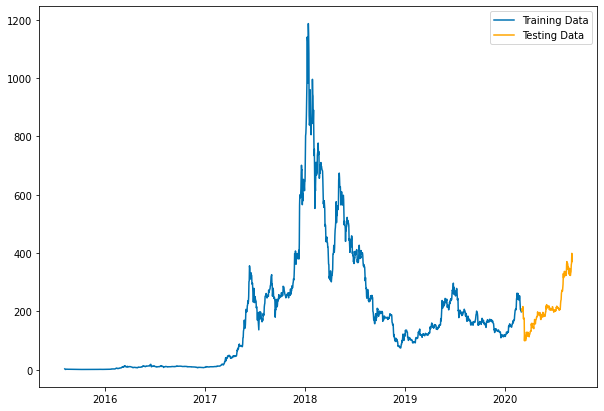

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(data_train.price, label='Training Data')
plt.plot(data_test.price, 'orange', label='Testing Data')
plt.legend()

In [ ]:
# Removing date before 2017 since it's useless
data_train = data_train['2017-01-01':]
data = data['2017-01-01':]

## Analysis

Decomposing Time Series into several components-Trend, Seasonality and Random noise

**Additive model = Trend + Seasonality + Random Noise**

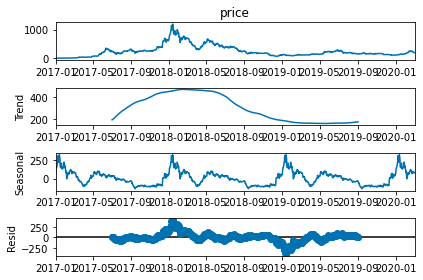

In [ ]:
import statsmodels.api as sm
seas_d=sm.tsa.seasonal_decompose(data_train.price, freq=365)

fig=seas_d.plot()
fig.set_figheight(4)

In [ ]:
# Stationary?
from statsmodels.tsa.stattools import adfuller

def test_adf(data_series):
    # H0: it's non stationary
    # H1: it's stationary
    result = adfuller(data_series)

    labels = ['ADF test statistic', 'p-value', 'Lags used', 'Observations used']
    for value, label in zip(result, labels):
        print("{}: {}".format(label, value))
    if result[1] <= 0.05:
        print("** H0 is rejected. Stationary.** ")
    else:
        print("** H0 is not rejected. Non stationary. **")

test_adf(data_train.price)

ADF test statistic: -2.585973926003788
p-value: 0.09593096123127842
Lags used: 20
Observations used: 1136
** H0 is not rejected. Non stationary. **


ADF test statistic: -5.890704451565092
p-value: 2.929106570401665e-07
Lags used: 23
Observations used: 1132
** H0 is rejected. Stationary.** 


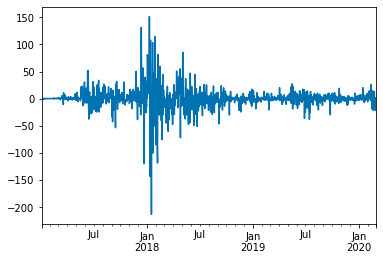

In [ ]:
data_train_diff = data_train.price - data_train.price.shift()
data_train_diff.dropna(inplace=True)
test_adf(data_train_diff)
data_train_diff.plot()

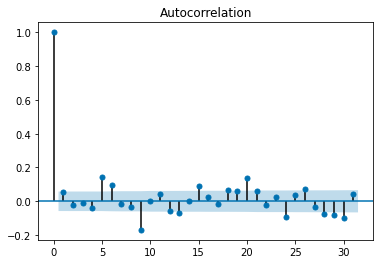

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data_train_diff)
plt.show()

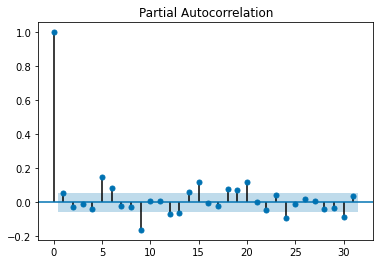

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data_train_diff)
plt.show()

## ARIMA

In [ ]:
X_train = data_train.price
X_test = data_test.price

In [ ]:
import pmdarima as pm

model = pm.auto_arima(X_train,
                      d=1,
                      seasonal=False,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=10223.003, Time=1.83 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10221.226, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10219.531, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10219.339, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10219.303, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10219.479, Time=0.68 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.051 seconds


In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1157
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -5108.652
Date:                Thu, 03 Sep 2020   AIC                          10219.303
Time:                        15:54:06   BIC                          10224.356
Sample:                             0   HQIC                         10221.210
                               - 1157                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       403.6808      4.679     86.282      0.000     394.511     412.851
===================================================================================
Ljung-Box (Q):                      209.81   Jarque-Bera (JB):             27371.12
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.09   Skew:                            -0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Bad results, order is (0,1,0)

### Rolling Forecast 

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

start = len(X_train)
end = start + len(X_test)
order = (0,1,0)

# number of steps ahead (like test lenght) without re-estimation
model = ARIMA(X_train, order=order).fit()
p = model.forecast(steps=len(X_test))

# rolling 1 step with re-estimation
p1 = pd.Series()
for i in range(start, end):
    model = ARIMA(data.price[:i], order=order).fit()
    yhat = model.forecast()[0]
    p1[data.index[i]] = yhat

# rolling 2 steps ahead with re-estimation
p2 = pd.Series()
for i in range(start, end, 2):
    model = ARIMA(data.price[:i], order=order).fit()
    yhat = model.forecast(steps=2)
    p2[data.index[i]] = yhat[0]
    if i+1 < len(data):
        p2[data.index[i+1]] = yhat[1]

# rolling 2 steps ahead without re-estimation
p3 = pd.Series()
model = ARIMA(X_train, order=order).fit()
for i in range(start, end, 2):
    yhat = model.forecast(steps=2)
    for j in range(2):
        if i+j < len(data):
            p3[data.index[i+j]] = yhat[j]

Test MSE in all steps: 5141.639
Test MSE in 1 step: 121.126
Test MSE in 2steps re-estimation: 167.810
Test MSE in 2steps no re-estimation: 5141.639


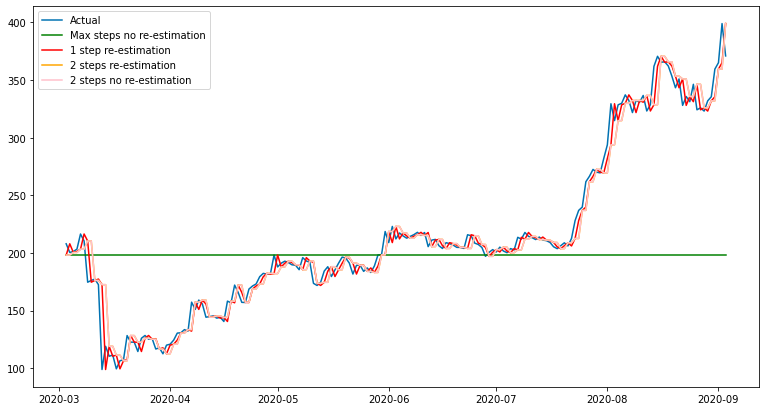

In [ ]:
from sklearn.metrics import mean_squared_error

for txt, p in zip(['all steps', '1 step', '2steps re-estimation', '2steps no re-estimation'], [p, p1, p2, p3]):
    error = mean_squared_error(X_test, p)
    print("Test MSE in {}: {:.3f}".format(txt, error))

# plot
plt.figure(figsize=(13,7))
plt.plot(X_test, label='Actual')
plt.plot(p, color='green', label='Max steps no re-estimation')
plt.plot(p1, color='red', label='1 step re-estimation')
plt.plot(p2, color='orange', label='2 steps re-estimation')
plt.plot(p2, color='pink', label='2 steps no re-estimation')
plt.legend()
plt.show()

## Random Forest

In [ ]:
#data_train = pd.DataFrame({'price':data_train})

In [ ]:
for i in range(1,8):
    column = "diff{}".format(i)
    data_train[column] = data_train.price - data_train.price.diff(i)

In [ ]:
data_train.dropna(inplace=True)
data_train.head()

,price,market_cap,total_volume,diff1,diff2,diff3,diff4,diff5,diff6,diff7
2017-01-08,9.748485,8.550908e+08,9.234354e+06,9.327367,9.638974,9.539322,10.462767,9.243632,7.988684,7.666365
2017-01-09,9.724888,8.533250e+08,1.715796e+07,9.748485,9.327367,9.638974,9.539322,10.462767,9.243632,7.988684
2017-01-10,9.972717,8.753883e+08,8.039755e+06,9.724888,9.748485,9.327367,9.638974,9.539322,10.462767,9.243632
2017-01-11,9.128747,8.015938e+08,1.478742e+07,9.972717,9.724888,9.748485,9.327367,9.638974,9.539322,10.462767
2017-01-12,9.109257,8.001660e+08,9.529482e+06,9.128747,9.972717,9.724888,9.748485,9.327367,9.638974,9.539322


In [ ]:
X_train = data_train.iloc[:,3:]
y_train = data_train.price

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=0)
rf.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

Text(0.5, 0, 'Relative Importance')

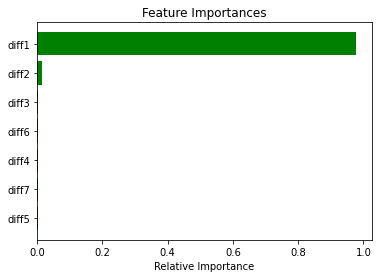

In [ ]:
importances = rf.feature_importances_
indices = np.argsort(importances)

#plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), X_train.columns[indices])
plt.xlabel('Relative Importance')


In [ ]:
# Refit the model
rf.fit(X_train[['diff1','diff2']], y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [ ]:
for i in range(1,8):
    column = "diff{}".format(i)
    data_test[column] = data_test.price - data_test.price.diff(i)

data_test.dropna(inplace=True)

In [ ]:
X_test = data_test[['diff1','diff2']]
y_test = data_test.price

predictions = rf.predict(X_test)

Test MSE in random forest: 184.836


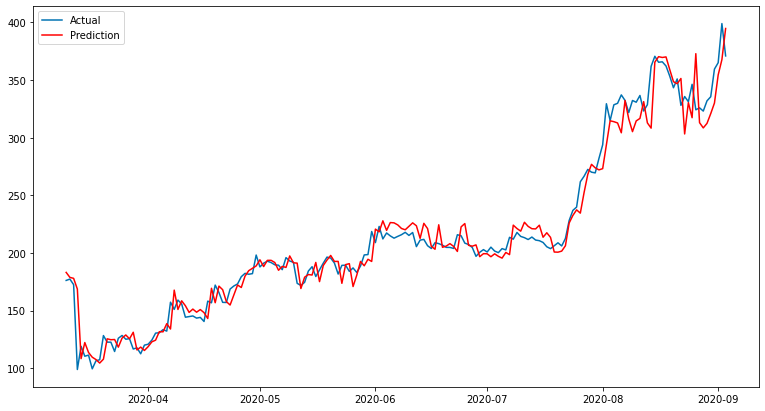

In [ ]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(y_test, predictions)
print("Test MSE in random forest: {:.3f}".format(error))

# plot
plt.figure(figsize=(13,7))
plt.plot(data_test.price, label='Actual')
plt.plot(data_test.index, predictions, color='red', label='Prediction')
plt.legend()
plt.show()

## LSTM

In [ ]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer'
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 2.3.0


In [ ]:
FEATURES_LEN = len(X_train.columns)

# 90% for training, 10% for validation
idx = round(len(X_train)*0.9)

In [ ]:
from sklearn.preprocessing import RobustScaler

# Y
yscaler = RobustScaler()
indices = y_train.index

y_train_norm = yscaler.fit_transform( y_train.values.reshape(-1,1) )
y_train_norm = pd.DataFrame(y_train_norm, index=indices)

y_train_norm, y_val_norm = y_train_norm[:idx], y_train_norm[idx:]

In [ ]:
# X
xscaler = RobustScaler()
indices = X_train.index

X_train_norm = xscaler.fit_transform( X_train.values.reshape(-1, FEATURES_LEN) )
X_train_norm = pd.DataFrame(X_train_norm, index=indices)

# Using training dataset with differences -> features
X_train_norm, X_val_norm = X_train_norm[:idx], X_train_norm[idx:]

# Adapt to LSTM sequence shape
X_train_norm = X_train_norm.values.reshape((X_train_norm.shape[0], 1, FEATURES_LEN))
X_val_norm = X_val_norm.values.reshape((X_val_norm.shape[0], 1, FEATURES_LEN))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(LSTM(8, input_shape=(1, FEATURES_LEN) ))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

es_callback = EarlyStopping(monitor="val_loss", min_delta=0, patience=5)
history = model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm, y_val_norm), shuffle=False, epochs=30, batch_size=32, verbose=2, callbacks=[es_callback])


Epoch 1/30
33/33 - 1s - loss: 1.9505 - val_loss: 0.1357
Epoch 2/30
33/33 - 0s - loss: 1.7186 - val_loss: 0.1171
Epoch 3/30
33/33 - 0s - loss: 1.5322 - val_loss: 0.1007
Epoch 4/30
33/33 - 0s - loss: 1.3649 - val_loss: 0.0863
Epoch 5/30
33/33 - 0s - loss: 1.2048 - val_loss: 0.0739
Epoch 6/30
33/33 - 0s - loss: 1.0628 - val_loss: 0.0631
Epoch 7/30
33/33 - 0s - loss: 0.9357 - val_loss: 0.0535
Epoch 8/30
33/33 - 0s - loss: 0.8058 - val_loss: 0.0449
Epoch 9/30
33/33 - 0s - loss: 0.6706 - val_loss: 0.0371
Epoch 10/30
33/33 - 0s - loss: 0.5418 - val_loss: 0.0304
Epoch 11/30
33/33 - 0s - loss: 0.4324 - val_loss: 0.0246
Epoch 12/30
33/33 - 0s - loss: 0.3481 - val_loss: 0.0198
Epoch 13/30
33/33 - 0s - loss: 0.2884 - val_loss: 0.0160
Epoch 14/30
33/33 - 0s - loss: 0.2485 - val_loss: 0.0130
Epoch 15/30
33/33 - 0s - loss: 0.2218 - val_loss: 0.0110
Epoch 16/30
33/33 - 0s - loss: 0.2032 - val_loss: 0.0098
Epoch 17/30
33/33 - 0s - loss: 0.1894 - val_loss: 0.0093
Epoch 18/30
33/33 - 0s - loss: 0.1785 - 

In [ ]:
def visualize_loss(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure(figsize=(8,4.5))
    plt.plot(epochs, loss, label="Training loss")
    plt.plot(epochs, val_loss, label="Validation loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

def visualize_plot(model, X, y, title):
    index = y.index
    pred = model.predict(X)
    pred = yscaler.inverse_transform(pred)
    y = yscaler.inverse_transform(y)
    plt.figure(figsize=(8,4.5))
    plt.plot(index, y, label='Actual')
    plt.plot(index, pred, "red", label='Prediction')
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Price (€)")
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
    plt.gcf().autofmt_xdate()

def print_mse(X, y, title):
    pred = model.predict(X)
    y_rescaled = yscaler.inverse_transform(y)
    pred_rescaled = yscaler.inverse_transform(pred)
    error = mean_squared_error(y_rescaled, pred_rescaled)
    print("{} MSE: {:.3f}".format(title, error))

Training MSE: 295.956


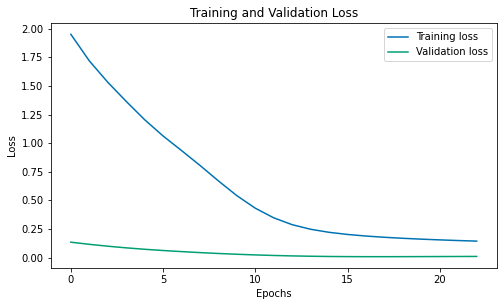

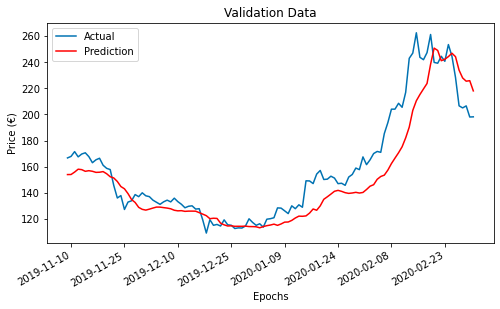

In [ ]:
visualize_loss(history)
visualize_plot(model, X_val_norm, y_val_norm, "Validation Data")
print_mse(X_val_norm, y_val_norm, 'Training')

Test MSE: 495.713


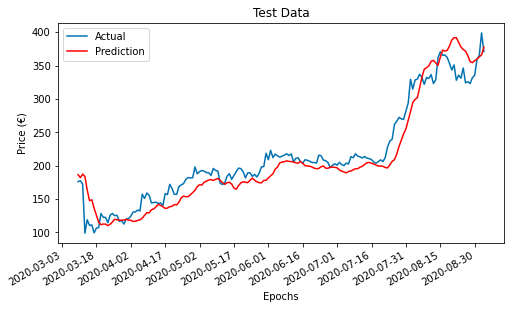

In [ ]:
X_test = data_test.iloc[:,3:]
y_test = data_test.price
indices = data_test.index

X_test_norm = xscaler.transform( X_test.values.reshape(-1, FEATURES_LEN) )
X_test_norm = pd.DataFrame(X_test_norm, index=indices)
X_test_norm = X_test_norm.values.reshape((X_test_norm.shape[0], 1, FEATURES_LEN))

y_test_norm = yscaler.transform( y_test.values.reshape(-1,1) )
y_test_norm = pd.DataFrame(y_test_norm, index=indices)

# Plot
visualize_plot(model, X_test_norm, y_test_norm, "Test Data")
print_mse(X_test_norm, y_test_norm, 'Test')